In [1]:
# Put these at the top of every notebook to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

General flow:

- import libraries
- set batch size
- create data object
- plot a few sample data
- set image size
- select architecture
- create learner object
- fit one cycle
- check the result

### Which libraries do we need?

In [2]:
# image processing & classification
from fastai.vision import *
# evaluation
from fastai.metrics import *

In [3]:
# Check GPU hardware is available
print(f'Cuda is available: {torch.cuda.is_available()}')
print(f'Cudnn backend enabled: {torch.backends.cudnn.enabled}')

Cuda is available: True
Cudnn backend enabled: True


---

### Set batch size

Set smaller size to prevent running out of GPU RAM

In [4]:
bs = 64

### Where is our data located?

For lesson 1, the dataset can be downloaded from `URLs.PETS`.

File size: 1.6GB

In [5]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [6]:
# Download and unpack. Won't redownload if file already exists.
path = untar_data(URLs.PETS)
path

PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet')

In [7]:
# check the content
path.ls()

[PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/models')]

In [8]:
# list all files
fnames = get_image_files(path/'images')
fnames[:3]

[PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/Bombay_70.jpg'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/pug_169.jpg'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/Ragdoll_96.jpg')]

Looks like the labels are in the file names. Use `regex` to extract them. Luckily, `fastai` has a data loader method that uses regex:

In [9]:
label_regex = r'/([^/]+)_\d+.jpg$'

Regex explanation (it is useful to start reading from the end):
- `/` forward slash, as part of path name. eg images`/`fname...
- `(...)` a group (matched text can be extracted for use later)
- `[]` a set of characters. eg `[a-z]`
- `^`  Matches the start of the string
- `[^/]+` Match all characters _except_ `/`
- `_\d+` underscore followed by 1 or more digits 0-9
- `.jpg` file extension
- `$` Matches the end of the string

In [10]:
# test the regex pattern
txt = "/home/paperspace/.fastai/data/oxford-iiit-pet/images/Bombay_70.jpg"
zz = re.compile(label_regex)
mo = zz.search(txt)
mo.group(1)

'Bombay'

---

### Create a data bunch object

dont forget to set transformations, image size to use, and batch size.

and dont forget to normalize

In [11]:
# Since our dataset has labels in the file name
# we'd want to use from_name_re
data = ImageDataBunch.from_name_re(path=path/'images',
                                   fnames=fnames,
                                   pat=label_regex,
                                   ds_tfms=get_transforms(),
                                   size=224,
                                   bs=bs).normalize(imagenet_stats)

# by default, validation percentage is 0.2

```python
ImageDataBunch.from_csv
ImageDataBunch.from_df
ImageDataBunch.from_folder
ImageDataBunch.from_lists
ImageDataBunch.from_name_func
ImageDataBunch.from_name_re
```

In [12]:
# classes in our dataset
print(data.classes)
print(len(data.classes))

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
37


### Show a few images

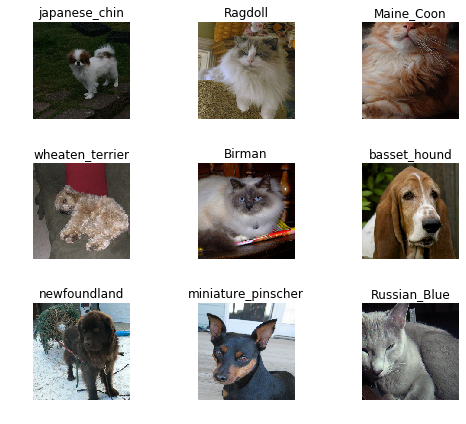

In [13]:
data.show_batch(rows=3, figsize=(7, 6))

---

### Create a `Learner` object

In [14]:
learn = create_cnn(data=data, arch=models.resnet34, metrics=error_rate)

In [ ]:
learn.model

### Fit one cycle

In [15]:
learn.fit_one_cycle(cyc_len=4) # 4 epochs per cycle

epoch,train_loss,valid_loss,error_rate
1,1.402074,0.343452,0.106225
2,0.572753,0.270124,0.095399
3,0.357154,0.221619,0.073748
4,0.268519,0.208878,0.069689


Note that `valid_loss` is larger than `train_loss`. This appears to be overfitting. But according to [Lesson 1 Discussion](https://forums.fast.ai/t/lesson-1-discussion/27332/515), it's not necessarily all bad

>as long as your validation metric is still improving.

In [16]:
# Save the current model weights
learn.save('stage-1', return_path=True)
# Save location: images/model

PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/models/stage-1.pth')

### Check the result

In [17]:
interp = ClassificationInterpretation.from_learner(learn=learn)

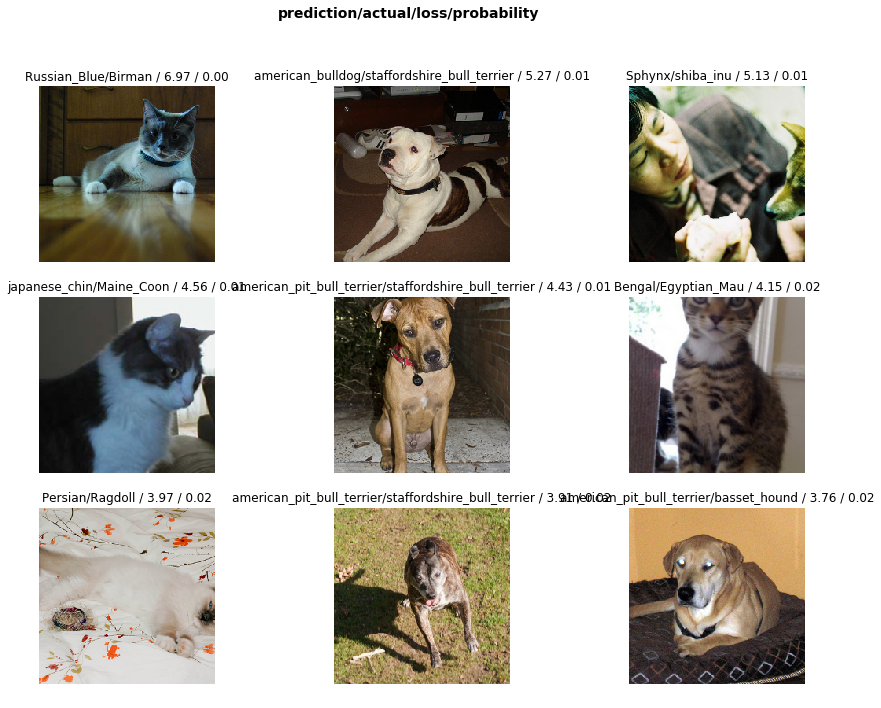

In [18]:
interp.plot_top_losses(k=9, figsize=(15,11))

In [19]:
interp.most_confused()

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 10),
 ('Ragdoll', 'Birman', 5),
 ('Bengal', 'Abyssinian', 4),
 ('Bengal', 'Egyptian_Mau', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Russian_Blue', 'Bombay', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('english_setter', 'english_cocker_spaniel', 3),
 ('Birman', 'Ragdoll', 2),
 ('Persian', 'Ragdoll', 2),
 ('Ragdoll', 'Persian', 2),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_setter', 'chihuahua', 2),
 ('havanese', 'yorkshire_terrier', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

Google the pictures of the most-confused breeds. See if you can do a better job spotting their differences!

---

### Unfreeze and finetune

Improve the model: fit with ranged learning rate. Reload weights if broken.

In [20]:
# unfreeze the model
learn.unfreeze()

In [21]:
# fit one more
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.551808,0.377453,0.123139


The `error_rate` got worse (0.069689 -> 0.123139)! 

Why?

Since the features from earlier layers are already very good, unfreezing them and retraining them can lead to the loss of good detectors (they're basically simple geometric lines and shapes). What we want to do is to retrain the later layers, so they could recombine the detected features for our purpose.

In [22]:
# undo the change if broken
learn = learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (5912 items)
[Category Bombay, Category pug, Category wheaten_terrier, Category english_cocker_spaniel, Category leonberger]...
Path: /home/paperspace/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (5912 items)
[Image (3, 103, 137), Image (3, 300, 256), Image (3, 333, 500), Image (3, 375, 500), Image (3, 334, 500)]...
Path: /home/paperspace/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList
y: CategoryList (1478 items)
[Category chihuahua, Category american_bulldog, Category yorkshire_terrier, Category yorkshire_terrier, Category Sphynx]...
Path: /home/paperspace/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (1478 items)
[Image (3, 300, 214), Image (3, 500, 334), Image (3, 400, 500), Image (3, 500, 376), Image (3, 500, 333)]...
Path: /home/paperspace/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)

In [24]:
# find a good learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


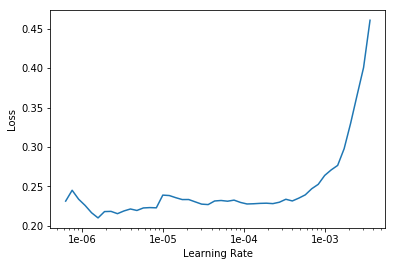

In [25]:
# plot the result
learn.recorder.plot()

Since the default learning rate is 0.003, a high value, the loss will be very high. Instead, we should set a range of learning rates below that (10x smaller is a good max).

In [26]:
# fit with a learning rate range
learn.unfreeze()
learn.fit_one_cycle(cyc_len=2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.240032,0.208063,0.072395
2,0.214103,0.202004,0.071719


If the error_rate doesn't improve, your max_lr could still be too high.